## Evaluating Approximated Ratios

In order to evaluate the quality of the approximated ratios we can use the fact that 
$$\frac{p(x|\theta_1)}{p(x|\theta_0)}\cdot p(x|\theta_0) = p(x|\theta_1)$$
The algorithms works as follow:
 1. Compute the approximated density ratios for $p(x|\theta_1)$ and $p(x|\theta_0)$.
 2. Compute the values of the ratio $p(s(x)|\theta_1)/p(s(x)|\theta_0)$ for data $\in \theta_0$.
 3. Resample the data $\in \theta_0$ using the ratio values as weight.
 4. Train a classifier to separate between data $\in \theta_1$ and the resampled dataset. Is expected that the classifier will works badly if the original data and the resampled data follows the same distribution. This only happens if the density ratios are being approximated correctly.
 5. Evaluate the ROC curves of the classifier in the data. AUC = 0.5 means that the density ratios were approximated correcly. Better AUC show that the approximation is bad.
 
In what follows we will show how to compute and evaluate the approximated density ratios.

In [73]:
import ROOT
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation
from xgboost_wrapper import XGBoostClassifier
from sklearn.externals import joblib
import matplotlib.pyplot as plt

from mlp import make_predictions, train_mlp
from utils import printFrame,makePlotName,makeSigBkg,saveFig, makeROC
import pdb
from xgboost_wrapper import XGBoostClassifier

import numpy as np

import os

%matplotlib inline

Setting some global variables (features, classifier used to approximate the ratios).

In [74]:
workspace_file = 'workspace_evaluating.root'
#vars_g = ['x']
vars_g = ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9']
dir='evaluating'
model_g='xgboost'
epochs_training = 40
clf = XGBoostClassifier(num_class=2, nthread=4, silent=1,
          num_boost_round=epochs_training, eta=0.5, max_depth=3)
verbose_printing=False

Define the models from where the data will be sampled. In this case 2 multivariate normal distributions.

In [75]:
mu_l = []
cov_l = []

mu_l.append([5.,5.,4.,3.,5.,5.,4.5,2.5,4.,3.5])
#mu_g.append([7.,8.,7.,6.,7.,8.,6.5,5.5,7.,6.5])
mu_l.append([4.,4.5,3.6,4.,6.,4.5,4.2,2.2,4.1,3.3])
mu_l.append([1.,0.5,0.3,0.5,0.6,0.4,0.1,0.2,0.1,0.3])

cov_l.append([[3.,0.,0.,0.,0.,0.,0.,0.,0.,0.],
         [0.,2.,0.,0.,0.,0.,0.,0.,0.,0.],
         [0.,0.,14.,0.,0.,0.,0.,0.,0.,0.],
         [0.,0.,0.,6.,0.,0.,0.,0.,0.,0.],
         [0.,0.,0.,0.,17.,0.,0.,0.,0.,0.],
         [0.,0.,0.,0.,0.,10.,0.,0.,0.,0.],
         [0.,0.,0.,0.,0.,0.,5.,0.,0.,0.],
         [0.,0.,0.,0.,0.,0.,0.,1.3,0.,0.],
         [0.,0.,0.,0.,0.,0.,0.,0.,1.,0.],
         [0.,0.,0.,0.,0.,0.,0.,0.,0.,9.3]])
cov_l.append([[3.5,0.,0.,0.,0.,0.,0.,0.,0.,0.],
         [0.,3.5,0.,0.,0.,0.,0.,0.,0.,0.],
         [0.,0.,9.5,0.,0.,0.,0.,0.,0.,0.],
         [0.,0.,0.,7.2,0.,0.,0.,0.,0.,0.],
         [0.,0.,0.,0.,4.5,0.,0.,0.,0.,0.],
         [0.,0.,0.,0.,0.,4.5,0.,0.,0.,0.],
         [0.,0.,0.,0.,0.,0.,8.2,0.,0.,0.],
         [0.,0.,0.,0.,0.,0.,0.,9.5,3.,0.],
         [0.,0.,0.,0.,0.,0.,0.,0.,3.5,0.],
         [0.,0.,0.,0.,0.,0.,0.,0.,0.,4.5]])
cov_l.append([[13.,0.,0.,0.,0.,0.,0.,0.,0.,0.],
         [0.,12.,0.,0.,0.,0.,0.,0.,0.,0.],
         [0.,0.,14.,0.,0.,0.,0.,0.,0.,0.],
         [0.,0.,0.,6.,0.,0.,0.,0.,0.,0.],
         [0.,0.,0.,0.,1.,0.,0.,0.,0.,0.],
         [0.,0.,0.,0.,0.,10.,0.,0.,0.,0.],
         [0.,0.,0.,0.,0.,0.,15.,0.,0.,0.],
         [0.,0.,0.,0.,0.,0.,0.,6.3,0.,0.],
         [0.,0.,0.,0.,0.,0.,0.,0.,11.,0.],
         [0.,0.,0.,0.,0.,0.,0.,0.,0.,1.3]])
# Statistical model
w = ROOT.RooWorkspace('w')

print 'Generating initial distributions'
cov_m = []
mu_m = []
mu_str = []
cov_root = []
vec = []
argus = ROOT.RooArgList()
#features
for i,var in enumerate(vars_g):
    w.factory('{0}[{1},{2}]'.format(var,-25,30))
    argus.add(w.var(var))

for glob in range(2):
    # generate covariance matrix
    cov_m.append(np.matrix(cov_l[glob]))
    cov_root.append(ROOT.TMatrixDSym(len(vars_g)))
    for i,var1 in enumerate(vars_g):
      for j,var2 in enumerate(vars_g):
        cov_root[-1][i][j] = cov_m[-1][i,j]
    getattr(w,'import')(cov_root[-1],'cov{0}'.format(glob))
    # generate mu vector
    mu_m.append(np.array(mu_l[glob]))
    vec.append(ROOT.TVectorD(len(vars_g)))
    for i, mu in enumerate(mu_m[-1]):
      vec[-1][i] = mu
    mu_str.append(','.join([str(mu) for mu in mu_m[-1]]))
    # multivariate gaussian
    gaussian = ROOT.RooMultiVarGaussian('f{0}'.format(glob),
          'f{0}'.format(glob),argus,vec[-1],cov_root[-1])
    getattr(w,'import')(gaussian)
  # Check Model
w.Print()


if verbose_printing == True:
    printFrame(w,['x0','x1','x7','x8'],[w.pdf('f0'),w.pdf('f1')],'distributions',['f0','f1']
    ,dir=dir,model_g=model_g,range=[-15,20],title='Distributions',x_text='x0',y_text='p(x)',print_pdf=True)



Generating initial distributions


Sampling data from the distributions.

Making Data


[]

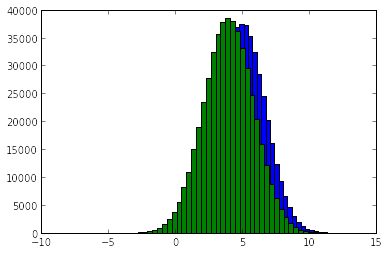

In [76]:
# Start generating data
num_train = 500000
num_test = 5000
no_train = False

print 'Making Data'
# Start generating data

   
# make data from root pdf
def makeDataFi(x, pdf, num):
    traindata = np.zeros((num,len(vars_g))) 
    data = pdf.generate(x,num)
    traindata[:] = [[data.get(i).getRealValue(var) for var in vars_g]
        for i in range(num)]
    return traindata
  
  # features
vars = ROOT.TList()
for var in vars_g:
    vars.Add(w.var(var))
x = ROOT.RooArgSet(vars)


train_data = np.zeros((num_train*2,len(vars_g) + 1))
test_data = np.zeros((num_test*2,len(vars_g) + 1))

if not no_train:
    #traindata[:num_train,0] =  makeDataFi(x,w.pdf('f0'), num_train).reshape(num_train)

    #traindata[num_train:,0] = makeDataFi(x,w.pdf('f1'), num_train).reshape(num_train)
    data_f0 =  makeDataFi(x,w.pdf('f0'), num_train)
    data_f1 = makeDataFi(x,w.pdf('f1'), num_train)

    train_data[:num_train,:len(vars_g)] =  data_f0

    train_data[num_train:,:len(vars_g)] = data_f1
 
    train_data[:num_train,-1] = np.ones(num_train)

#testdata[:num_test,0] = makeDataFi(x, w.pdf('f0'), num_test).reshape(num_test)
#testdata[num_test:,0] = makeDataFi(x, w.pdf('f1'), num_test).reshape(num_test)
test_data[:num_test,:len(vars_g)] =  makeDataFi(x,w.pdf('f0'), num_test)

test_data[num_test:,:len(vars_g)] = makeDataFi(x,w.pdf('f1'), num_test)

test_data[num_test:,-1] = np.ones(num_test)

plt.hist(data_f0[:,0],bins=50)
plt.hist(data_f1[:,0],bins=50)
plt.plot()


Tran classifiers on the sampled data

In [77]:

model_file = 'train'
traindata = train_data[:,:-1]
targetdata = train_data[:,-1]
if model_g == 'mlp':
    train_mlp((traindata, targetdata), save_file='{0}/{1}_F0_F1.pkl'.format(dir,model_file),n_epochs=epochs_training)
else:
    rng = np.random.RandomState(1234)
    indices = rng.permutation(traindata.shape[0])
    traindata_random = traindata[indices]
    targetdata_random = targetdata[indices]
    scores = cross_validation.cross_val_score(clf, traindata_random, targetdata_random)
    print "Accuracy: {0} (+/- {1})".format(scores.mean(), scores.std() * 2)
    clf.fit(traindata_random,targetdata_random)
    #clf.plot_importance_matrix(vars_names)
    joblib.dump(clf, '{0}/{1}_F0_F1.pkl'.format(dir,model_file))


Accuracy: 2.53032553995 (+/- 0.0135329382044)


In [78]:
# Prediction function 
def predict(filename, traindata,model_g='mlp', sig=1):
  sfilename,k,j = filename.split('/')[-1].split('_')
  sfilename = '/'.join(filename.split('/')[:-1]) + '/' +  sfilename
  j = j.split('.')[0]
  sig = 1
  if k <> 'F0':
    k = int(k)
    j = int(j)
    sig = 1 if k < j else 0
    filename = '{0}_{1}_{2}.pkl'.format(sfilename,min(k,j),max(k,j))
  if model_g == 'mlp':
    return make_predictions(dataset=traindata, model_file=filename)[:,sig]
  else:
    clf = joblib.load(filename)
    if clf.__class__.__name__ == 'NuSVR':
      output = clf.predict(traindata)
      return np.clip(output,0.,1.)
    else:
      return clf.predict_proba(traindata)[:,sig]


Compute score distributions.

In [79]:

bins = 80
low = 0.
high = 1.  
c1_g=''
  
print 'Generating Score Histograms'

w.factory('score[{0},{1}]'.format(low,high))
s = w.var('score')
  
def saveHisto(w,outputs,s,bins,low,high,k='F0',j='F1'):
    
    print 'Estimating {0} {1}'.format(k,j)
    for l,name in enumerate(['sig','bkg']):
      data = ROOT.RooDataSet('{0}data_{1}_{2}'.format(name,k,j),"data",
          ROOT.RooArgSet(s))
      hist = ROOT.TH1F('{0}hist_{1}_{2}'.format(name,k,j),'hist',bins,low,high)
      values = outputs[l]
      #values = values[self.findOutliers(values)]
      for val in values:
        hist.Fill(val)
        s.setVal(val)
        data.add(ROOT.RooArgSet(s))
      norm = 1./hist.Integral()
      hist.Scale(norm) 
        
      s.setBins(bins)
      datahist = ROOT.RooDataHist('{0}datahist_{1}_{2}'.format(name,k,j),'hist',
            ROOT.RooArgList(s),hist)
      histpdf = ROOT.RooHistFunc('{0}histpdf_{1}_{2}'.format(name,k,j),'hist',
            ROOT.RooArgSet(s), datahist, 1)

      getattr(w,'import')(hist)
      getattr(w,'import')(data)
      getattr(w,'import')(datahist) # work around for morph = w.import(morph)
      getattr(w,'import')(histpdf) # work around for morph = w.import(morph)
      score_str = 'score'
      # Calculate the density of the classifier output using kernel density 
      #w.factory('KeysPdf::{0}dist_{1}_{2}({3},{0}data_{1}_{2},RooKeysPdf::NoMirror,2)'.format(name,k,j,score_str))


numtrain = traindata.shape[0]       

outputs = [predict('{0}/{1}_F0_F1.pkl'.format(dir,model_file),traindata[targetdata==1],model_g=model_g),
            predict('{0}/{1}_F0_F1.pkl'.format(dir,model_file),traindata[targetdata==0],model_g=model_g)]

saveHisto(w,outputs,s, bins, low, high)

if verbose_printing == True:
    can = printFrame(w,['score'],[w.function('sighistpdf_F0_F1'),w.function('bkghistpdf_F0_F1')], makePlotName('full','all',type='hist',dir=dir,c1_g=c1_g,model_g=model_g),['signal','bkg'],
  dir=dir,model_g=model_g,y_text='score(x)',print_pdf=True,title='Pairwise score distributions',use_rootnotes=False)


Generating Score Histograms
Estimating F0 F1


In [80]:
def findOutliers(x):
  q5, q95 = np.percentile(x, [5,95])  
  iqr = 2.*(q95 - q5)
  outliers = (x <= q95 + iqr) & (x >= q5 - iqr)
  return outliers
def singleRatio(f0,f1):
  ratio = f1 / f0
  ratio[np.abs(ratio) == np.inf] = 0 
  ratio[np.isnan(ratio)] = 0
  return ratio

def evalDist(x,f0,val):
  iter = x.createIterator()
  v = iter.Next()
  i = 0
  while v:
    v.setVal(val[i])
    v = iter.Next()
    i = i+1
  return f0.getVal(x)

Compute approximated density ratios and do reweighting.

Calculating ratios


[]

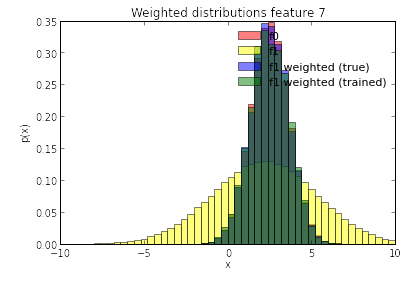

In [81]:

print 'Calculating ratios'
true_dist = True
npoints = 50

score = ROOT.RooArgSet(w.var('score'))
getRatio = singleRatio

# NN trained on complete model
F0pdf = w.function('bkghistpdf_F0_F1')
F1pdf = w.function('sighistpdf_F0_F1')


# Transforming f1 into f0
data_f1 = train_data[train_data[:,-1] == 0.]
data_f0 = train_data[train_data[:,-1] == 1.]
xarray = data_f1[:,:-1]
testtarget = data_f1[:,-1]

outputs = predict('{0}/{1}_F0_F1.pkl'.format(dir,model_file),xarray,model_g=model_g)

F1fulldist = np.array([evalDist(score,F1pdf,[xs]) for xs in outputs])
F0fulldist = np.array([evalDist(score,F0pdf,[xs]) for xs in outputs])

completeRatio = getRatio(F0fulldist,F1fulldist)

if len(vars_g) == 1:
    F1dist = np.array([evalDist(x,w.pdf('f1'),[xs]) for xs in xarray])
    F0dist = np.array([evalDist(x,w.pdf('f0'),[xs]) for xs in xarray])
else:
    F1dist = np.array([evalDist(x,w.pdf('f1'),xs) for xs in xarray])
    F0dist = np.array([evalDist(x,w.pdf('f0'),xs) for xs in xarray])

trueRatio = getRatio(F1dist, F0dist)

#trueIndexes = findOutliers(trueRatio)
#completeIndexes = findOutliers(completeRatio)
#indexes = np.logical_and(trueIndexes,completeIndexes)
#trueRatio = trueRatio[indexes]
#completeRatio = completeRatio[indexes]
#data_f1_red = data_f1[indexes]
data_f1_red = data_f1

bins = 50
feature = 7
x_range = (-10.,10.)
# Transfering distributions
# Doing histogram manipulation
fig,ax = plt.subplots()
colors = ['b-','r-','k-']
colors_rgb = ['blue','red','black']
    
hist,bins = np.histogram(data_f1[:,feature],bins=bins, range=x_range,density=True)


hist_transfered,bins_1 = np.histogram(data_f1_red[:,feature],weights=trueRatio,bins=bins, range=x_range,density=True)
hist_transfered_clf,bins_2 = np.histogram(data_f1_red[:,feature],bins=bins,weights=completeRatio, range=x_range,density=True)
hist0,bins0 = np.histogram(data_f0[:,feature], bins=bins, range=x_range,density=True)

widths = np.diff(bins)

ax.bar(bins[:-1], hist0,widths,label='f0',alpha=0.5,color='red')
ax.bar(bins[:-1], hist,widths,label='f1',alpha=0.5,color='yellow')
ax.bar(bins[:-1], hist_transfered,widths,label='f1 weighted (true)',
    alpha=0.5,color='blue')
ax.bar(bins[:-1], hist_transfered_clf,widths,label='f1 weighted (trained)',
        alpha=0.5,color='green')

ax.legend(frameon=False,fontsize=11)
ax.set_xlabel('x') 
ax.set_ylabel('p(x)') 
if len(vars_g) > 1:
    ax.set_title('Weighted distributions feature {0}'.format(feature))
else:
    ax.set_title('Weighted distributions')
file_plot =  makePlotName('all','transf',type='hist_v{0}'.format(feature),model_g=model_g) 
fig.savefig('{0}/plots/{1}/{2}.png'.format(dir,model_g,file_plot))

#saveFig(xarray, [true_transfer, data_f0[:,0]], makePlotName('all','transf',type='hist'),title='Transfered distribution',labels=['Transfer True', 'Truth'],hist=True, print_pdf=True,dir=dir)
plt.plot()

Resampling data from f1 using the ratios as weights

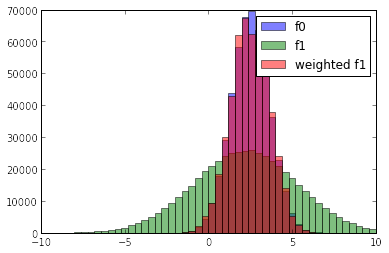

In [82]:
# Weighting with approximated densities
ratio_norm = completeRatio / completeRatio.sum()
#ratio_norm = trueRatio/trueRatio.sum()
data_f1_idx = np.random.choice(range(data_f1.shape[0]),data_f1.shape[0],p=ratio_norm)
data_f1_re_clf = data_f1[data_f1_idx]
traindata_weighted_clf = traindata.copy()
traindata_weighted_clf[targetdata==0] = data_f1_re_clf[:,:-1]
# Weighting with true densities
ratio_norm = trueRatio / trueRatio.sum()
data_f1_idx = np.random.choice(range(data_f1.shape[0]),data_f1.shape[0],p=ratio_norm)
data_f1_re_true = data_f1[data_f1_idx]
traindata_weighted_true = traindata.copy()
traindata_weighted_true[targetdata==0] = data_f1_re_true[:,:-1]
#traindata[targetdata == 0] = data_f0[:,:-1]
plt.hist(data_f0[:,feature],label='f0',alpha=0.5,bins=bins,range=x_range)
plt.hist(data_f1[:,feature],label='f1',alpha=0.5,bins=bins,range=x_range)
plt.hist(data_f1_re_clf[:,feature],label='weighted f1',alpha=0.5,bins=bins,range=x_range)
plt.legend()


Evaluate the approximation by training a classifier to classify between the weighted data and the original

In [83]:
xgb = XGBoostClassifier(num_class=2, nthread=4, silent=1,
          num_boost_round=50, eta=0.1, max_depth=3)
rng = np.random.RandomState(1234)
indices = rng.permutation(traindata.shape[0])
traindata = traindata[indices]
targetdata = targetdata[indices]
traindata_weighted_clf = traindata_weighted_clf[indices]
traindata_weighted_true = traindata_weighted_true[indices]
scores = cross_validation.cross_val_score(xgb, traindata_weighted_clf, targetdata)
print "Accuracy: {0} (+/- {1})".format(scores.mean(), scores.std() * 2)
xgb.fit(traindata_weighted_clf,targetdata)
predictions_weighted_clf = xgb.predict_proba(traindata_weighted_clf)[:,1]
xgb.fit(traindata_weighted_true,targetdata)
predictions_weighted_true = xgb.predict_proba(traindata_weighted_clf)[:,1]
xgb.fit(traindata,targetdata)
predictions = xgb.predict_proba(traindata)[:,1]
print 'Trained'
# Fit also on original data and another on weighted data with true ratios


Accuracy: 1.47303094775 (+/- 0.000782237553734)
Trained


[]

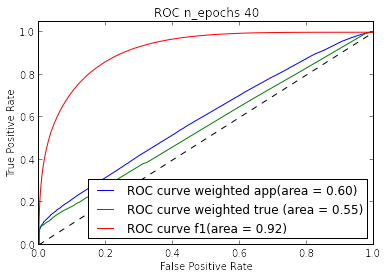

In [84]:
fpr_clf, tpr_clf, _  = roc_curve(targetdata.ravel(),predictions_weighted_clf.ravel())
roc_auc_clf = auc(fpr_clf, tpr_clf)
fpr_true, tpr_true, _  = roc_curve(targetdata.ravel(),predictions_weighted_true.ravel())
roc_auc_true = auc(fpr_true, tpr_true)
fpr, tpr, _  = roc_curve(targetdata.ravel(),predictions.ravel())
roc_auc = auc(fpr, tpr)
fig = plt.figure()
plt.plot(fpr_clf, tpr_clf, label='ROC curve weighted app(area = %0.2f)' % roc_auc_clf)
plt.plot(fpr_true, tpr_true, label='ROC curve weighted true (area = %0.2f)' % roc_auc_true)
plt.plot(fpr, tpr, label='ROC curve f1(area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('{0} n_epochs {1}'.format('ROC',epochs_training))
plt.legend(loc="lower right")
plt.savefig('{0}/plots/{1}/{2}_{3}.png'.format(dir,model_g,'roc_eval',epochs_training))

plt.plot()